- so there is clearly some kind of issue with the model because the val accuracy is extremly low

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import load_img
import keras

In [17]:
input_path = []
labels = []

base_dir = "/Users/naomigong/Coding/ML Projects/facialEmotions/train/train"

for class_name in os.listdir(base_dir):
    path_name = os.path.join(base_dir, class_name)
    if os.path.isdir(path_name):
        #this gets each image and path is the image file
        for image in os.listdir(path_name):
            if 'angry' in path_name:
                labels.append(0)
            elif 'disgust' in path_name:
                labels.append(1)
            elif 'fear' in path_name:
                labels.append(2)
            elif 'happy' in path_name:
                labels.append(3)
            elif 'neutral' in path_name:
                labels.append(4)
            elif 'sad' in path_name:
                labels.append(5)
            elif 'surprise' in path_name:
                labels.append(6)
            
            input_path.append(os.path.join(path_name, image))


In [18]:
emotions = pd.DataFrame()
emotions['images'] = input_path
emotions['emotion'] = labels
emotions.head()
emotions = emotions.sample(frac =1).reset_index(drop = True)

In [19]:
#check for corrupted images
for image in emotions['images']:
    if 'jpg' not in image:
        print(image)

import PIL
corrupted = []
for image in emotions['images']:
    try:
        img = PIL.image.open(image)
    except:
        corrupted.append(image)
print(corrupted)
#no corrupted images

['/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/sad/Training_18012516.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/angry/Training_59851309.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/happy/Training_66373729.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/fear/Training_61297982.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/happy/Training_34849527.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/fear/Training_61607854.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/neutral/Training_95854199.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/happy/Training_91571616.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/fear/Training_69812475.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/train/surprise/Training_96533198.jpg', '/Users/naomigong/Coding/ML Projects/facialEmotions/train/t

In [20]:
emotions['emotion'] = emotions['emotion'].astype('str')
emotions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   images   28709 non-null  object
 1   emotion  28709 non-null  object
dtypes: object(2)
memory usage: 448.7+ KB


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#this is image augmentations
train_generator = ImageDataGenerator(
    rescale = 1./255, #normal images
    rotation_range = 40, #degree range for random rotations
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest' #fills the gone area when rotating etc with nearing pixel

)

#input split
from sklearn.model_selection import train_test_split
#2 variables for dataframe as a whole
train, test = train_test_split(emotions, test_size = 0.2, random_state = 42)

train_iterator = train_generator.flow_from_dataframe(
    train,
    x_col = 'images', 
    y_col = 'emotion', 
    target_size =(48, 48), 
    batch_size = 512, 
    class_mode = 'sparse'
    color_mode = 'grayscale'
    )

val_generator = ImageDataGenerator(rescale = 1./255)

val_iterator = val_generator.flow_from_dataframe(
    test,
    x_col = 'images', 
    y_col = 'emotion', 
    target_size =(48, 48), 
    batch_size = 512, 
    class_mode = 'sparse'
    color_mode = 'grayscale'
    )

val_iterator

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.


In [27]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
#Sequential means adds each layer in a sequential manner
model = Sequential([
    #In first layer need input shape
    #16 is number of filters
    Conv2D(16, kernel_size=(3,3), activation = 'relu', input_shape = (48, 48, 3)),
    MaxPool2D((2,2)),
    Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    #(2,2) is the kernel size
    MaxPool2D((2,2)),
    Flatten(), #1D array
    #512 represents number of neurons
    Dense(512, activation = 'relu'),
    Dense(7, activation='softmax')


])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,975 (2.11 MB)

 Trainable params: 551,975 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Check the shape of a single batch from the iterator
for inputs, targets in train_iterator:
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")
    break


Inputs shape: (512, 48, 48, 3)
Targets shape: (512,)


In [30]:
for inputs, targets in train_iterator:
    print(f"Inputs shape: {inputs.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Sample targets: {targets[:5]}")
    break


Inputs shape: (512, 48, 48, 3)
Targets shape: (512,)
Sample targets: [4. 3. 3. 0. 0.]


In [32]:
history = model.fit(train_iterator, epochs = 50, validation_data = val_iterator)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.4371 - loss: 1.4776 - val_accuracy: 0.4573 - val_loss: 1.4035
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 256ms/step - accuracy: 0.4444 - loss: 1.4424 - val_accuracy: 0.4746 - val_loss: 1.3708
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.4587 - loss: 1.4231 - val_accuracy: 0.4761 - val_loss: 1.3663
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.4749 - loss: 1.3894 - val_accuracy: 0.4815 - val_loss: 1.3381
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.4648 - loss: 1.3929 - val_accuracy: 0.4958 - val_loss: 1.3197
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.4837 - loss: 1.3649 - val_accuracy: 0.5002 - val_loss: 1.2880
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.4962 - loss: 1.3393 - val_accuracy: 0.5190 - val_loss: 1.2667
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.4975 - loss: 1.3160 - val_accu

In [33]:
loss, accuracy = model.evaluate(val_iterator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.5717 - loss: 1.1225 
Loss: 1.1359121799468994
Accuracy: 0.5708812475204468


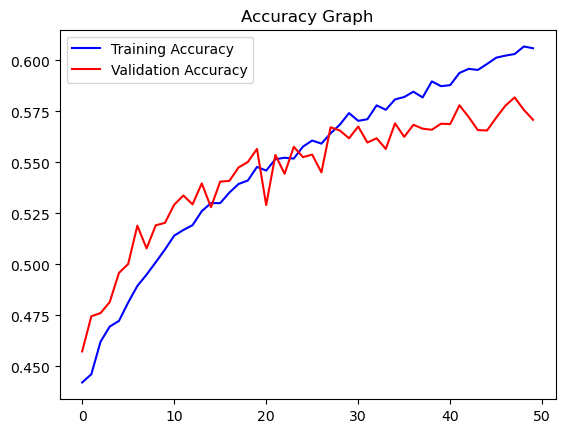

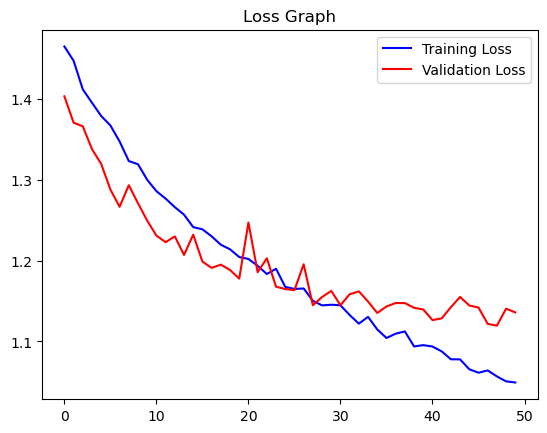

In [35]:
#for training
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Loss Graph')
plt.legend()